## Template for the evaluation of the muon experiment
## $~~~~$  "Proof of the muon spin precession in a magnetic field"

This notebook builds on the `lifetime.ipynb` notebook with which the muon lifetime was measured.
You can either expand that or use this template for the evaluation of the long-term measurement
and transfer required code sections.

Even with data collected over a week, an exact measurement of the size of the muon spin is not possible. Additional minima in the parameter space further complicate the fit. In addition, fitting an exponentially damped oscillation signal to data with statistical fluctuations is not straightforward, as random periodicities can easily hide the actual signal.

Instead, another evaluation method is applied, which is commonly used in searches for deviations from a standard theory (so-called "new physics"). In this specific case, we consider the small expected modulation of the lifetime distribution as a deviation from purely exponential behavior, which we view as the "null hypothesis" in the sense of a hypothesis test. For this, all parameters of the model with spin modulation of the lifetime are fixed, and only the amplitude of the spin modulation is left free in the fit. For a modulation amplitude of zero, the model corresponds to the null hypothesis. A significant deviation of the determined value of the modulation amplitude from the fit is considered evidence for the existence of muon spin.

How clearly the signal is seen is expressed as the "significance." In statistics, this is the a posteriori probability of obtaining an even smaller agreement between the adapted model and the null hypothesis than actually observed. This information can be fully determined from the likelihood function (preferably the profile likelihood) for different values of the modulation amplitude. Background information can be found in the statistics chapter of the "Blue Book" or in the jupyter tutorials `negLogLFits.ipynb` and `advancedFitting.ipynb` at the URL https://etpwww.etp.kit.edu/~quast/jupyter/.

### Procedure for detecting muon spin

As an alternative to the simple exponential decay law, we formulate a parameterization of the number of decays detected in the upper detector at time $t$, which includes a (small) additional component (see experiment instructions in the Blue Book):

  $${\rm pdf}_{\rm signal} = 
    K \cdot e^{-\frac{t}{\tau}} \cdot \left[1 + \bar{A}\cdot \cos{(\omega t + \delta)}\right]$$

To use this probability density in the fit, it must be normalized in the sensitive time interval $t\in[a,b]$. The integral of the unnormalized distribution required for this is most easily determined using a computer algebra system.

The result is:

  $$ K^{-1}(\tau, \bar{A}, \omega, \delta, a, b) = 
  {\tau  \left(\frac{\bar{A} \left(e^{-\frac{a}{\tau}} (\cos (a \omega +\delta ) - \tau \omega \sin (a   \omega +\delta ))+e^{-\frac{b}{\tau}} (\tau  \omega  \sin (b \omega +\delta )-\cos (b \omega +\delta   ))\right)}{\tau ^2 \omega ^2+1}+e^{-\frac{a}{\tau }}-e^{-\frac{b}{\tau }}\right)}$$

The total probability density is a sum of the expected signal distribution and the (constant) background:

  $$ {\rm pdf}_\rm{bkg}(a, b) = \frac{1}{b-a} $$

With a background fraction $f$, the overall expression is:
 
 $$ {\rm pdf} (t; \tau, f, \bar{A}, \omega, \delta, a, b) = 
      (1-f) \cdot {\rm pdf}_{\rm signal}   
     + f \cdot {\rm pdf}_{\rm bkg} $$ 

With a suitable choice of parameters, this formula applies to decays where the decay particle is detected in the upper detector. For particles in the detector below the copper absorber, the modulation is phase-shifted by 180°. By choosing the parameter $\delta$ accordingly, the same code can then also be used for the lower detector.                                

### *Pyhton*-Code for the probability density

The following code cell provides the necessary *Python code* for the probability density:

In [139]:
import numpy as np
import matplotlib.pyplot as plt

# set valid range of measured lifetimes (maximum values given here, may not be optimal)
a0=5.0e-07
b0=14.5e-06


# PDFs for exponential decay and modulation by spin rotations

def exp_pdf(t, tau=2.19e-6, fbg=0.1, a=a0, b=b0):
    """
    Probability density function for the decay time of a myon using the Kamiokanne-Experiment.
    The pdf is normed for the interval (a, b).

    :param t: decay time
    :param fbg: background
    :param tau: expected mean of the decay time
    :param a: the minimum decay time which can be measured
    :param b: the maximum decay time which can be measured
    :return: probability for decay time x
    """
    pdf1 = np.exp(-t / tau) / tau / (np.exp(-a / tau) - np.exp(-b / tau))
    pdf2 = 1. / (b - a)
    return (1 - fbg) * pdf1 + fbg * pdf2

# set some initial values
tau0=2.19e-6
omega0=3.5e6
delta0=0. 
Abar_top0=0.05
f_top0=0.5
Abar_bot0=0.05
f_bot0=0.5

def spin_pdf(t, tau=2.19e-6, fbg=0.3, a_bar = 0.2, delta=0, omega=7.78e+04, a = a0, b = b0):
    """
    Probability density function for the decay time of a myon using the "Properties of Cosmic Muons"-experiment in the
    physics master advanced laboratory course (with applied magnetig field)
    The pdf is normed for the interval (a, b).

    :param t: decay time
    :param tau: expected mean of the decay time
    :param fbg: percentage of background (assumed to be flat) 
    :param a_bar: percentage of the modulation due to spin precession
    :param delta: phase shift between spin polarization and electron/positron impulse (should be 0 or pi)
    :param omega: precession angular frequency
    :param a: the minimum decay time which can be measured
    :param b: the maximum decay time which can be measured
    :return: probability for decay time x
    """
    modulation_pdf = np.exp(-t/tau)*(1 + a_bar*np.cos(delta + t*omega))
    modulation_pdf_integral = tau*(np.exp(-a/tau) - np.exp(-b/tau) + a_bar*(np.exp(-a/tau) * (np.cos(delta + a*omega) - tau*omega*np.sin(delta + a*omega)) - np.exp(-b/tau) * (np.cos(delta + b*omega) - tau*omega*np.sin(delta + b*omega))) / (1 + tau**2 * omega**2))
    bg_pdf = 1/(b - a)
    full_pdf = (1-fbg) * modulation_pdf/modulation_pdf_integral + fbg*bg_pdf
    return full_pdf

def spin_pdf_top(t, tau=tau0, Abar_top=Abar_top0, omega=omega0, delta=delta0, f_top=f_top0, a=a0, b=b0):
    # for top detector: Abar = Abar_top
    return spin_pdf(t, tau=tau, a_bar=Abar_top, omega=omega, delta=delta, fbg = f_top, a=a, b=b)

# pdf for decay election in bottom detectors
def spin_pdf_bot(t, tau=tau0, Abar_bot=Abar_bot0, omega=omega0, delta=delta0, f_bot=f_bot0, a=a0, b=b0):
    # for bottom detector: delta_bot = delta_top+pi
    return spin_pdf(t, tau=tau, a_bar= Abar_bot, omega=omega, delta=delta+np.pi, fbg = f_bot, a=a, b=b)

# check proper normalization of pdfs
import scipy.integrate as integrate
print("** check normalisation of PDFs (must be 1. !) :")
print('  normalisation exp_pdf_top():', integrate.quad(exp_pdf, a0, b0))
print('  normalisation spin_pdf_top():', integrate.quad(spin_pdf_top, a0, b0))
print('  normalisation spin_pdf_bot():', integrate.quad(spin_pdf_bot, a0, b0))

** check normalisation of PDFs (must be 1. !) :
  normalisation exp_pdf_top(): (0.9999999999999999, 1.1102230246251564e-14)
  normalisation spin_pdf_top(): (1.0, 1.5123343539530073e-12)
  normalisation spin_pdf_bot(): (1.0, 1.4690726603209928e-12)


### Task: Graphical representation of the expected signal

To get a sense of the magnitude of the modulation signal, you should first graphically represent the distribution. This also checks the correctness of the implementation of the functions in *Python*. It is also important to choose the appropriate number of bins in the histograms for later analysis.

First, the expected oscillation frequency $\omega_\mathrm{lit}$ must be calculated from the measured magnetic field $B$.

Furthermore, the range to be fitted for the probability density is determined: On the one hand, too short decay times $t \lesssim 0.6 \mathrm{\mu s}$ are filtered out because they are mainly dominated by muon captures in copper, with much shorter decay times than the muon's lifetime. On the other hand, the upper limit is determined by the maximum measurement time of the experimental setup $t \gtrsim 14.5 \mathrm{\mu s}$ can be filtered out. You can experiment around with the exact values if you want to.

For the background fraction, it is estimated that $f_\mathrm{bg} \approx 30%$. For the strength of the precession modulation, a very visible fraction of $\bar{A} \approx 15%$ is chosen. In reality, this fraction is only a few percent! The phase shift $\delta$ is determined by the decay kinematics and the polarization of the incoming muons. Physically meaningful are only the following two values:

$\delta = \begin{cases} 0 & \textrm{oberer Detektor} \\ \pi & \textrm{unterer Detektor} \end{cases}$.

Slightly different values from zero or $\pi$ result from time delays in the signal processing chain relative to the muon passage.

The muon lifetime is set to the literature value $\tau \approx 2.19\mathrm{\mu s}$.

It is advisable to draw possible limits for the frequency classes (= bins) of a histogram directly into the diagram. On the one hand, more bins are necessary to better resolve the modulation caused by the precession, but on the other hand, too many bins lead to high statistical uncertainties.

You can find a template for solving this task in the following code cell:

In [140]:
import time
import numpy as np     
import pandas as pd                 # Powerful package for the handling of large datasets
import matplotlib.pyplot as plt     # Graphics library
# Package for model fits ("Wrapper-Function in PhyPraKit)
from PhyPraKit import mFit, hFit, k2hFit

The expected  omega is: 7.78e+04


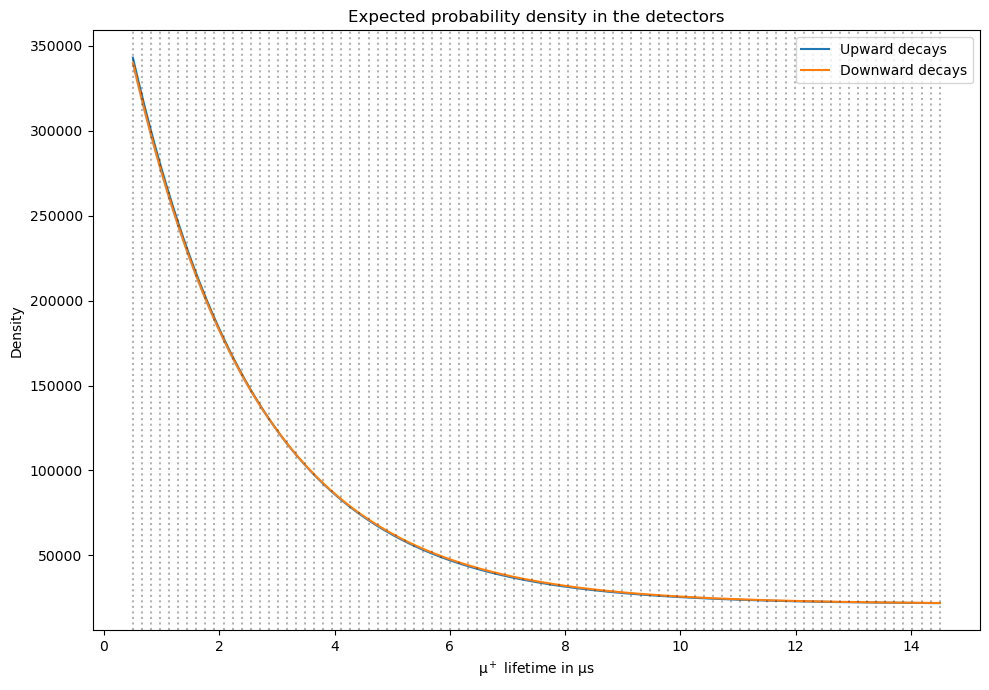

In [141]:
import scipy.constants as c
import matplotlib.pyplot as plt

# The expected omega is calculated from the measured magnetic field (B-field)
g_lit = np.abs(c.physical_constants["muon g factor"][0])
e = c.physical_constants["elementary charge"][0]
m = c.physical_constants["muon mass"][0]
B = 9.131e-5 #TODO: Calculation of the V-field (in Tesla)
omega_lit = (g_lit*e*B)/(2*m) #TODO: Insert equation for the calculation of omega
print(f"The expected  omega is: {omega_lit:.2e}")

# Set the draw range to reasonably
limits = (5.0e-07, 1.45e-05)  #TODO: Set reasonable values for the lower and upper bounds 'limits = (lower_bound, upper_bound)'
t = np.linspace(limits[0], limits[1], 1000)

lande_top = spin_pdf(t, tau=2.19e-6, fbg=0.30, a_bar=0.15, delta=0, omega=omega_lit, a=limits[0], b=limits[1])
lande_bot = spin_pdf(t, tau=2.19e-6, fbg=0.30, a_bar=0.15, delta=np.pi, omega=omega_lit, a=limits[0], b=limits[1])

plt.subplots(figsize=(10,7))
plt.title("Expected probability density in the detectors")
plt.plot(t*1e6, lande_top, label="Upward decays")
plt.plot(t*1e6, lande_bot, label="Downward decays")
#TODO: Find a reasonable value for the number of frequency-classes in the histogram
for x in np.linspace(limits[0], limits[1], 90)*1e6:
    #                                       ^--- number of frequency-classes
    plt.axvline(x, color="black", linestyle=":", alpha=0.3)
plt.legend(loc="best")
plt.ylabel("Density")
plt.xlabel(r"$\mathrm{\mu^+}$ lifetime in $\mathrm{\mu s}$")
plt.tight_layout()
#plt.savefig('Exp_prob.png', dpi=300)
plt.savefig('Exp_prob.png')
plt.show()

### Task: Read in of measurement data and quality control

In the next step, the measured data is read. As in the experiment part "Measurement of Muon Lifetime," it is even more important with the long-term measurement data to first ensure the quality of the (unsupervised) recorded data and, if necessary, clean up the dataset if there are interruptions in data acquisition, periods with high noise rates, or other irregularities.

First, it is recommended to check the quality of the data:

  -  Statistical information on data acquisition
  -  Temporal course of the recorded data, i.e., the number of events observed in time intervals over a few minutes
  -  Pulse height distributions in the detectors for each primary and secondary puls

As a template, you can use the corresponding code from the notebook *lifetime.ipynb* and the function *dataquality_check()* defined there.

In [142]:
LT1 = "/home/shivamkumar/Documents/KIT COURSES/Lab/Exp1/sam/muon_properties/analysis/lifetime_one_week.txt"   # data in csv-Format produced with config `lifetime_setup.yaml`

# convenient abbreviations for column names
# - for measurements with 3 panels
dp_columns_3p = { 0:'EvId',  1:'EvT', 2:'tDead', 3:'dT', 
               4: 'h1A',  5:'p1A', 6: 'I1A',
               7: 'h1B',  8:'p1B', 9: 'I1B', 
               10: 'h1C', 11:'p1C', 12:'I1C', 
               13:'h2A', 14:'p2A', 15:'I2A', 
               16:'h2B', 17:'p2B', 18:'I2B', 
               19:'h2C', 20:'p2C', 21:'I2C',
                }
# - for measurements with 4 panels
dp_columns_4p = { 0:'EvId',  1:'EvT', 2:'tDead', 3:'dT', 
               4: 'h1A',  5:'p1A', 6: 'I1A',
               7: 'h1B',  8:'p1B', 9: 'I1B', 
               10: 'h1C', 11:'p1C', 12:'I1C', 
               13: 'h1D', 14:'p1D', 15:'I1D', 
               16:'h2A', 17:'p2A', 18:'I2A', 
               19:'h2B', 20:'p2B', 21:'I2B', 
               22:'h2C', 23:'p2C', 24:'I2C',
               25:'h2D', 26:'p2D', 27:'I2D'
                }

# read the data and store in a pandas dataframe
lifetime_df = pd.read_csv( LT1,
     skiprows=1, comment='#', delimiter='\t', header=None).rename(columns = dp_columns_4p)
# adjust time unit - was µs in old data, now s
time_unit= 1.e-6 # adjust if time is in µs
 

** Infomation on data:
  Date of 1st Event:  Thu Jan  1 01:29:05 1970
  Date of last Event:                           Thu Jan  1 01:29:06 1970
     triggered Events: 68373842  selected Pulses: 156889  Duration: 0.5926719901617616s  Rate: 115365401.3Hz
     mean time between selected pulses: 3.8e-06s


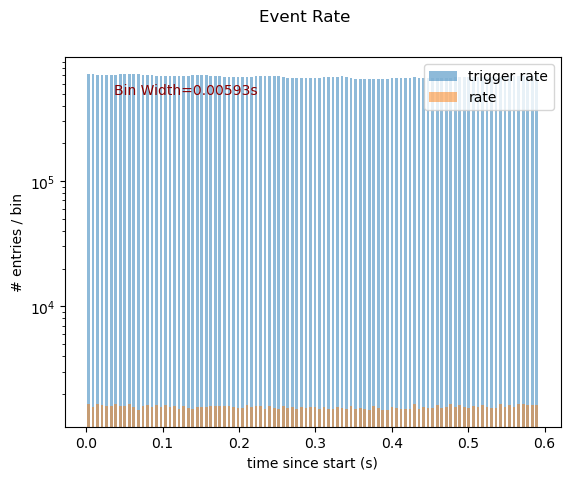

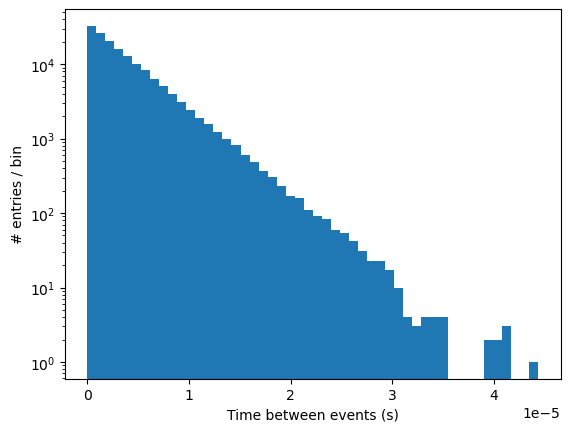

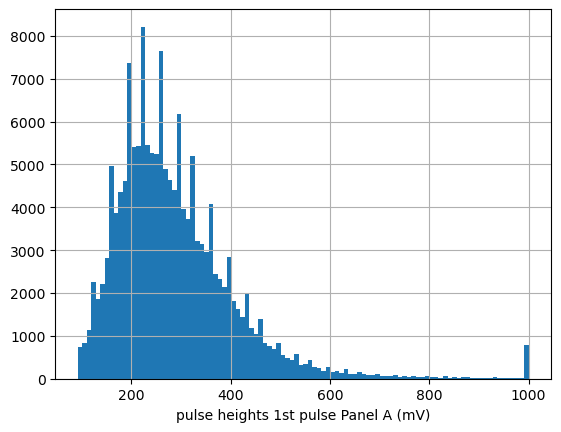

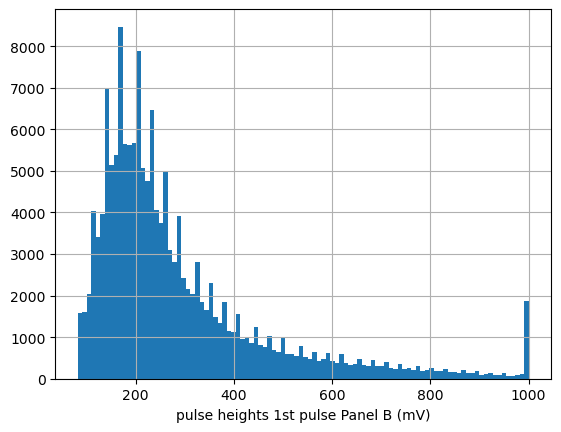

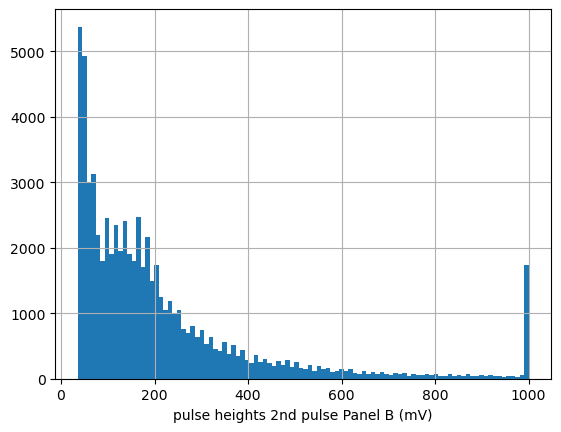

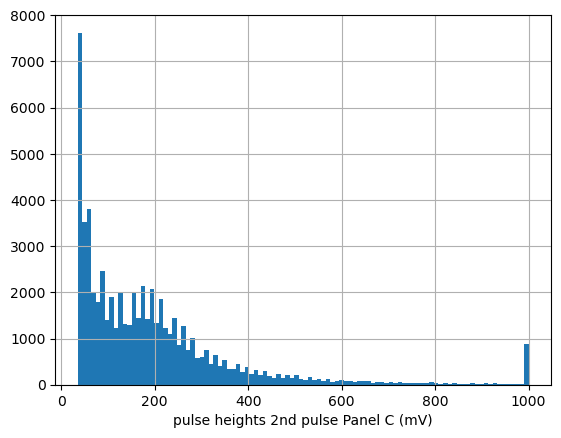

In [143]:
# -->> insert your code here  <<--

# Load data (adjust path/format as needed)
import time
from scipy.stats import trim_mean

def dataquality_check(df):
    """check data quality of data in dataframe df
    """
    # print information  on data (from header)
    header = df[['EvT','EvId', 'tDead']]
    print('** Infomation on data:')

    # event times in seconds 
    EvT_s = header['EvT']*time_unit  # event times in s 

    # plot trigger and event rate
    print('  Date of 1st Event: ', time.ctime(EvT_s.values[0]))
    print('  Date of last Event:', 25*' ', time.ctime(EvT_s.values[-1]))

    NEvents = header['EvId'].values[-1]
    Nsel = len(header['EvId'])
    Duration = (EvT_s.values[-1] - EvT_s.values[0])
    print('     triggered Events: {}  selected Pulses: {}  Duration: {}s  Rate: {:.1f}Hz'.format(
        NEvents, Nsel, Duration, NEvents/Duration))
    Tbetween = np.diff(EvT_s.to_numpy()) # in seconds
    print('     mean time between selected pulses: {:.2g}s'.format(Tbetween.mean()))

    T0 = EvT_s[0]
    #  -  number of events triggered between selected events in data set
    dN = np.diff(header['EvId'].to_numpy())
    Nbins= 100
    Wbin = Duration/Nbins
    _ = plt.hist(EvT_s[1:] - T0, weights = dN, bins=Nbins, rwidth=0.6, label='trigger rate', alpha=0.5)
    _ = plt.hist(EvT_s[1:] - T0, bins=Nbins, rwidth=0.6, label='rate', alpha=0.5, )
    plt.text(0.1, 0.9, "Bin Width={:.3g}s".format(Wbin), color = 'darkred', transform=plt.gca().transAxes)
    plt.yscale('log')
    plt.suptitle('Event Rate')
    plt.xlabel('time since start (s)')
    plt.ylabel('# entries / bin')
    plt.legend(loc='upper right')
    plt.savefig('Event_rate.png')
    plt.show()

    # plot time between events                                
    _ = plt.hist(Tbetween[Tbetween < Tbetween.mean()*100], bins=50, log=True)
    plt.xlabel('Time between events (s)')
    plt.ylabel('# entries / bin')
    plt.savefig('Time_btw_Events.png')
    plt.show()

    # show pulse height distributions
    df['h1A'].hist(bins=100, log=False)
    plt.xlabel('pulse heights 1st pulse Panel A (mV)')
    plt.savefig('Pusle_height_1st_Pulse_A.png')
    plt.show()
    df['h1B'].hist(bins=100, log=False)
    plt.xlabel('pulse heights 1st pulse Panel B (mV)')
    plt.savefig('Pusle_height_1st_Pulse_B.png')
    plt.show()
    df[df['h2B']>0.]['h2B'].hist(bins=100, log=False)
    plt.xlabel('pulse heights 2nd pulse Panel B (mV)')
    plt.savefig('Pusle_height_2nd_Pulse_B.png')
    plt.show()
    df[df['h2C']>0.]['h2C'].hist(bins=100, log=False)
    plt.xlabel('pulse heights 2nd pulse Panel C (mV)')
    plt.savefig('Pusle_height_2nd_Pulse_C.png')
    plt.show()

# Perform data quality check
dataquality_check(lifetime_df)


### Task: Filtering of the measured data

Next, suitable events need to be selected for the planned data analysis. The muons should preferably have been stopped in the copper plate in the magnetic field, and events with clearly detected positrons from muon decay should be selected. Distinctions must be made between events with positrons emitted upward and downward.

Information about the modulation of the exponential distribution is present in both the data with decay positrons in the upper and lower detectors. However, the significance is higher in the upper detector due to the more favorable signal-to-background ratio. Therefore, it is sufficient to initially perform the analysis only for the upper detectors.

The selected signature for the upper detector layers consists of a coincidence of the first pulses in the upper detector layers A and B and no pulse in detectors C (and also not in D if its data is used). Delayed second pulses should only be present in detector layers A and B (for upwards decaying muons).

The signature for decays with downward-emitted decay electrons is identical for the first pulses, but delayed pulses should only be present in detector layers C or D in this case.

The thresholds for pulse heights should be adjusted so that, on the one hand, as much signal content and as little background as possible are included. On the other hand, the total number of events must still be sufficient to fit the probability densities well. After an initial adjustment of the probability density, these cuts should be iteratively modified until the most optimal result is achieved. The target variable in this manual optimization is the relative uncertainty of the parameter $\bar{A}$.

As a template, you can use the code from the notebook *lifetime.ipynb* and the function *select()* defined there.

In [144]:
# -->> insert your code here  <<--

# top_selected = ...

# pulse height thresholds for trigger pulse in Panels A & B
th_1A_low = 75
th_1A_high = 1100 # not effective above 1. !
th_1B_low = 75
th_1B_high = 1100
th_1C_low = 50.
th_1C_high = 1100.
th_1D_low = 50.
th_1D_high = 1100.

# pulse height thresholds for 2nd pulse in Panels B ("Top") & C ("Bottom")
th_2A = 75.
th_2B = 75.
th_2C = 75.
th_2D = 75.

# -----------------------------------------------

def select(df, signature = None):
    """Define acceptance for "good evnts"
       - myon stopped in copper plate
       - decay to top or bottom detectors
    """

    # criteria for 2-fold coincidences
    mask_AB = (df['h1A'] > th_1A_low)  & (df['h1A'] < th_1A_high) & \
                (df['h1B'] > th_1B_low)  & (df['h1B'] < th_1B_high) 
    mask_AC = (df['h1A'] > th_1A_low)  & (df['h1A'] < th_1A_high) & \
                (df['h1C'] > th_1C_low)  & (df['h1C'] < th_1C_high)
    mask_BC = (df['h1B'] > th_1B_low)  & (df['h1B'] < th_1B_high) & \
                (df['h1C'] > th_1C_low)  & (df['h1C'] < th_1C_high) 
    mask_AD = (df['h1A'] > th_1A_low)  & (df['h1A'] < th_1A_high) & \
                (df['h1D'] > th_1D_low)  & (df['h1D'] < th_1D_high)
    mask_BD = (df['h1B'] > th_1B_low)  & (df['h1B'] < th_1B_high) & \
                (df['h1D'] > th_1D_low)  & (df['h1D'] < th_1D_high) 
    mask_CD = (df['h1C'] > th_1C_low)  & (df['h1C'] < th_1C_high) & \
                (df['h1D'] > th_1D_low)  & (df['h1D'] < th_1D_high) 
    
    # criteria for stopped muon in copper plate
    mask_stopped = (df['h1A'] > th_1A_low)  & \
                   (df['h1A'] < th_1A_high) & \
                   (df['h1B'] > th_1B_low)  & \
                   (df['h1B'] < th_1B_high) & \
                   (df['h1C'] < th_1C_low)  & \
                   (df['h1D'] < th_1D_low) 
 
    # bookean mask for 2nd pulses: one valid pulse in either A, B, C or D    
    mask2_up =  (df['h2A'] > th_2A) | (df['h2B'] > th_2B) 
    mask2_down =  (df['h2C'] > th_2C) | (df['h2D'] > th_2D)  

    if signature == "all":        

      # select set of conditions
        filter_mask = (mask_AB | mask_AC | mask_BC |  \
                       mask_AD | mask_BD | mask_BD ) & \
                      (mask2_up | mask2_down)

      # apply filter conditions
        sel = lifetime_df[ filter_mask]
        print('shape of selected data:    ', sel.shape)
        return sel
    
    elif signature == "top":
      # select events with stopped muon in copper and decay to top detectors
        Tsel = df[ mask_stopped & mask2_up]
        print('shape top detector:    ', Tsel.shape)
        return Tsel
        
    elif signature == "bottom":
      # selecct events with stopped muon in copper decay to bottom detectors
        Bsel = df[ mask_stopped & mask2_down]
        print('shape bottom detector: ', Bsel.shape)
        return Bsel
    else:
        print('!!! unknown signature')
        return None

shape of selected data:     (111449, 28)
 ** number of selected events:  92612


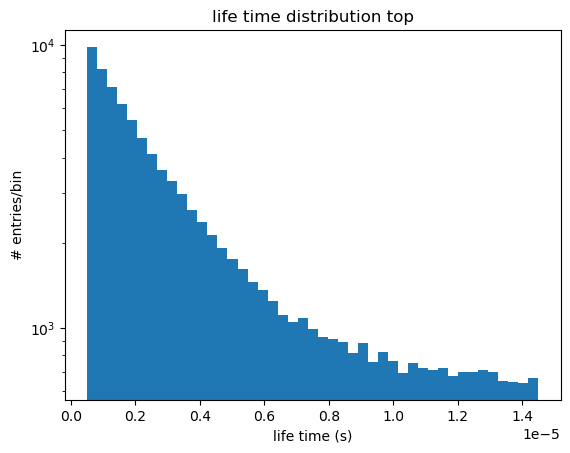

In [145]:
# Filter events

a0 = 0.5e-6
b0 = 14.5e-6

Tsel = select(lifetime_df, "all")

# Plot lifetime distribution
# --------------------------

# - acceptance definition: valid life time interval



# - select data in range [a0, b0]
dT = Tsel[ (Tsel['dT'] > a0*1e9) & (Tsel['dT'] < b0*1e9)].dT.values*1.0e-9
print(" ** number of selected events: ", len(dT))

# show top result in a histogram
nbins = 45
bin_entries, bin_edges, _ = plt.hist(dT, bins=nbins)
plt.title('life time distribution top')
plt.xlabel('life time (s)')
plt.ylabel('# entries/bin')
#plt.ylim(0,1000)
plt.yscale('log')
plt.savefig('LT_top.png')
plt.show()


<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2058651/3084370024.py:17: SyntaxWarning: invalid escape sequence '\D'
  axis_labels=['life time  ' + '$\Delta$t (s)', 'Probability Density  pdf($\Delta$t; *p)'],
/tmp/ipykernel_2058651/3084370024.py:17: SyntaxWarning: invalid escape sequence '\D'
  axis_labels=['life time  ' + '$\Delta$t (s)', 'Probability Density  pdf($\Delta$t; *p)'],
/tmp/ipykernel_2058651/3084370024.py:18: SyntaxWarning: invalid escape sequence '\m'
  data_legend='$\mu$ lifetime data',


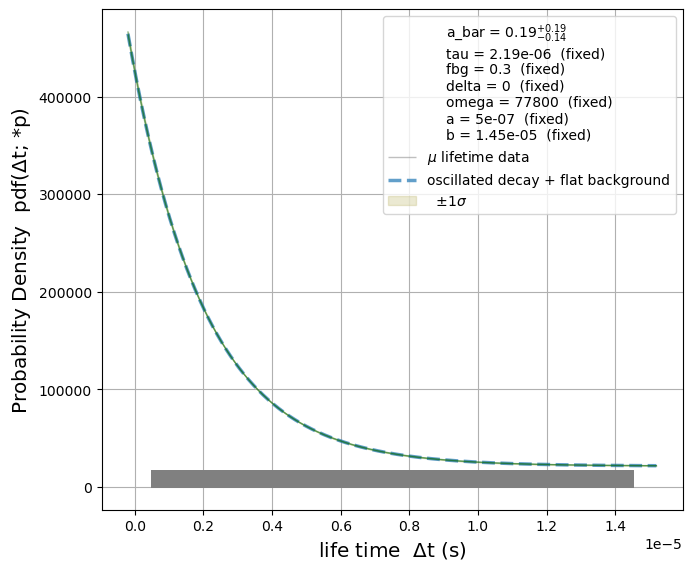

In [146]:
a=0.5e-06
b=1.45e-05
tau = 2.19e-6
fbg = 0.30
#a_bar = 0.15
delta = 0
omega = 7.78e+04

results_modulated = mFit( spin_pdf,
    data=dT,  
    limits=('a_bar', 0., 1.),
    fixPars= ['tau', 'fbg','delta','omega','a','b'], 
    neg2logL=True,
    plot=True,
    plot_band=True,
    plot_cor=False,
    axis_labels=['life time  ' + '$\Delta$t (s)', 'Probability Density  pdf($\Delta$t; *p)'],
    data_legend='$\mu$ lifetime data',
    model_legend='oscillated decay + flat background' )



### Task: Adjustments of the pure exponential model ("Null Hypothesis") and the model with spin modulation

After the data selection, the rest of the analysis is carried out exclusively based on the measured lifetimes now contained in the arrays *Lt_top* (or *Lt_bot*).

The measured decay times are plotted in a histogram. Initially, the probability density without precession modulation is fitted to the histogrammed data. Therefore, $\bar{A} = 0$, $\omega = 0$, $\delta = 0$. The parameters $a$ and $b$ are set to the previously determined limits, and the background fraction is restricted to the physically reasonable interval $f_\mathrm{bg} \in [0, 1]$.

The fit yields values for $\tau$ and $f_\mathrm{bg}$, which are used as fixed parameters in a second fit for the probability density with precession modulation. Furthermore, $\omega$ and $\delta$ are now set to the previously calculated values. Therefore, only the $\bar{A}$ parameter is adjusted, while it is restricted to the physically reasonable interval $\bar{A} \in [0, 1]$.

You can perform the fits to the histograms quite analogously to the examples from the notebook `lifetime.ipynb`, either using the wrapper functions in *PhyPraKit* (*hFit* or *k2hFit* for *kafe2*) or directly with the classes and methods of *kafe2*.

### Task: Statistical evaluation and determination of the signal significance

Whether a significant oscillation has been observed is decided based on the values of the negative log likelihood function that the fits provide as output. In the last step, the likelihood values with and without precession modulation are compared using the found function parameters.

The negative logarithm of the likelihood ratio is used as the test statistic (see the statistics chapter in the blue book. The procedure is based on the so-called "Neyman-Pearson Lemma"):

$$ z^2 = -2 \cdot nl\mathcal{L} = -2\cdot \left(
    \displaystyle\sum_{i=1}^{n_d} \, -\ln\left(\mathrm{pdf_1}(x_i, \vec p)\right) \,
    - \displaystyle\sum_{i=1}^{n_d} \, -\ln\left(\mathrm{pdf_2}(x_i, \vec p)\right)
     \right) $$

From this difference, the square of the significance (the so-called $z$-value) for the parameter $\bar{A}$ arises directly. In other words, the distance from zero measured in standard deviations. A slightly less accurate determination is also obtained by dividing the value of $\bar{A}$ from the fit by its uncertainty:
$$ z \simeq \hat{\bar{A}} / \sigma_\bar{A}\,.$$ 

By using the cumulative distribution function $\Phi$ of the standard normal distribution, positive values of $z$ can be converted into a $p$-value, commonly used in professional statistics:

$$ p = 1 - 2\,(1 - \Phi(\mathrm{z}; \, \mu = 0, \sigma = 1)), \, z\ge 0\,.$$

The $p$-value is the a-posteriori probability that the observed signal is due to a statistical fluctuation of the null hypothesis. If this probability is too small, the null hypothesis is rejected in favor of the alternative. In this context, $z=0$ corresponds to $p=50\%$, $z=1$ corresponds to $p=13.6\%$, $z=2$ corresponds to $p=2.1\%$, and $z=3$ corresponds to $p=0.13\%$ (and so on).

To determine $z$, you can directly use the values output by the fits for *gof* = "goodness of fit" or $-2 \cdot nl\mathcal{L}$. These quantities are simply appropriately normalized values of the negative logarithm of the likelihood function (*2nlL*). When forming the likelihood ratio (or subtracting the *2nlL* values) of the two fits, this normalization factor cancels out.

You can also directly determine $z^2$ by substituting the values of the fitted parameters into the formula given above.
In the end, you should summarize the result.

<>:16: SyntaxWarning: invalid escape sequence '\ '
<>:16: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipykernel_2058651/2631529989.py:16: SyntaxWarning: invalid escape sequence '\ '
  axis_labels=['dT (s)', '  # \  f(x, *par)'],


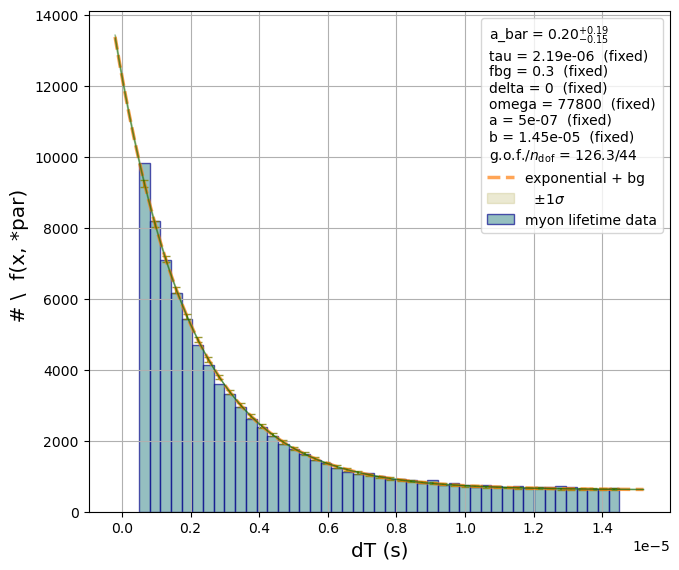


*==* binned ML Fit Result:
 parameter names:        ['a_bar' 'tau' 'fbg' 'delta' 'omega' 'a' 'b']
 goodness-of-fit: 126
 parameter values:       [2.04236054e-01 2.19000000e-06 3.00000000e-01 0.00000000e+00
 7.78000000e+04 5.00000000e-07 1.45000000e-05]
 neg. parameter errors:  [-0.14822789]
 pos. parameter errors:  [0.19455046]
 correlations : 
 [[1.]]


In [147]:
from PhyPraKit.phyFit import hFit

#  
# ---  perform fit  to Top data with phyFit.hFit 
#       using the histogram produced above 
#

hFit_result = hFit( 
       spin_pdf,               # the fit model
       bin_entries, bin_edges,  # bin entries and bin edges
       limits=('a_bar', 0., 1.),    # parameter limits 
       fixPars= ['tau', 'fbg','delta','omega','a','b'],# fix parameter(s) 
       plot=True,               # plot data and model
       plot_band=True,          # plot model confidence-band
       plot_cor=False,          # plot profiles likelihood and contours
       axis_labels=['dT (s)', '  # \  f(x, *par)'], 
       data_legend = 'myon lifetime data',    
       model_legend = 'exponential + bg',
       return_fitObject = True
    )
# Print results 
pvals, perrs, cor, gof, pnams = hFit_result.getResult().values()
print('\n*==* binned ML Fit Result:')
print(" parameter names:       ", pnams)
print(" goodness-of-fit: {:.3g}".format(gof))
print(" parameter values:      ", pvals)
print(" neg. parameter errors: ", perrs[:,0])
print(" pos. parameter errors: ", perrs[:,1])
print(" correlations : \n", cor)  


In [150]:
from scipy.stats import chi2, norm
# Reuse parameters from the previous fit
a=0.5e-06
b=1.45e-05
tau = 2.19e-6
fbg = 0.30
a_bar = 0.2
delta = 0
omega = 7.78e+04


pdf_non_modulated = exp_pdf(dT, tau=tau, fbg=fbg, a=a, b=b)
pdf_modulated = spin_pdf(dT, tau=tau, fbg=fbg, a_bar=a_bar, delta=delta, omega=omega, a=a, b=b)

non_modulated_log_likelihood = -2 * np.sum(np.log(pdf_non_modulated))
modulated_log_likelihood =  -2 * np.sum(np.log(pdf_modulated ))

# calculate test statistic (-2 * negative log-Likelihood difference)
Delta = non_modulated_log_likelihood - modulated_log_likelihood

# The z-score can be determined if the difference is exactly one parameter
z_score = np.sqrt(Delta)

print("Negative Log Likelihood:")
print("\tnon-modulated: {:.2f}".format(non_modulated_log_likelihood))
print("\t    modulated: {:.2f}".format(modulated_log_likelihood))
print("\t        Delta: {:f}".format(Delta))
print("\t      z-score: {:.2f}".format(z_score))
print("\t            p: {:.2%}".format( 1 - norm.cdf(z_score) ) )


Negative Log Likelihood:
	non-modulated: -2146382.51
	    modulated: -2146384.35
	        Delta: 1.843908
	      z-score: 1.36
	            p: 8.72%


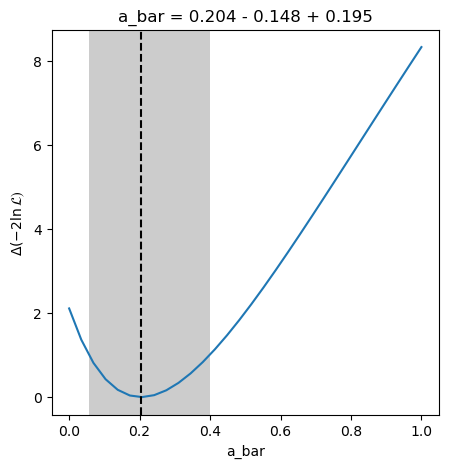

In [149]:
p2nlL = hFit_result.plot_Profile('a_bar', range=(0., 1.) )

### Task: Comment on your results

### Optional: Measurement of the muon's Landé Factor ("g-factor")

Whether you obtained a high significance depends on both statistical fluctuations in the data and your selection criteria. If you have $z$-values of more than three in both the upper and lower detectors, you can attempt to fit the precession frequency. To make optimal use of the data, a simultaneous fit of the data to the two lifetime distributions with decay positrons in the upper and lower detectors should be performed. This can be achieved using the "MultiFit" class implemented in kafe2, which allows you to combine fits to the data from top and bottom detectors. Parameters present in both models, i.e., the mean muon lifetime $\tau$ and the precession frequency $\omega$, are set equal in both model functions, while the other parameters are treated independently in each.

Such a fit is reliably successful when combining data collected over several weeks.